# Demo for Xarray Zarr and GCSFS
A very simple example of reading data in from POSIX files, reading into memory via Xarray, then outputting to Zarr through Xarray's experimental `to_zarr` method. 

In [1]:
import xarray as xr
import gcsfs
from glob import glob
from tqdm import tqdm
from dask.diagnostics import ProgressBar
from dask.distributed import LocalCluster, Client
from xarray.backends.zarr import ZarrStore
import dask

import numpy as np
%matplotlib inline
ProgressBar()

In [2]:
def preprocess(ds):
    return ds.set_coords(['lat_bnds', 'lon_bnds', 'crs'])

In [3]:
ddir = '/swot/SUM03/copernicus/dataset-duacs-rep-global-merged-allsat-phy-l4-v3/'
all_files = sorted(glob(ddir + '????/*.nc'))
one_year_files = sorted(glob(ddir + '1993/*.nc'))
one_file = ddir + '1993/dt_global_allsat_phy_l4_19930702_20170110.nc'

In [4]:
%time ds = xr.open_mfdataset(one_year_files, preprocess=preprocess, autoclose=True)

CPU times: user 7.28 s, sys: 375 ms, total: 7.65 s
Wall time: 7.68 s


In [5]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 365)
Coordinates:
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
    lat_bnds   (latitude, nv) float32 -90.0 -89.75 -89.75 -89.5 -89.5 -89.25 ...
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
    lon_bnds   (longitude, nv) float32 0.0 0.25 0.25 0.5 0.5 0.75 0.75 1.0 ...
    crs        int32 -2147483647
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
    err        (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
    ugosa      (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
    vgosa      (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunksize=

In [7]:
%time sla_timeseries = ds.sla.mean(dim=('longitude', 'latitude')).load()

CPU times: user 15.9 s, sys: 7.36 s, total: 23.3 s
Wall time: 17.6 s


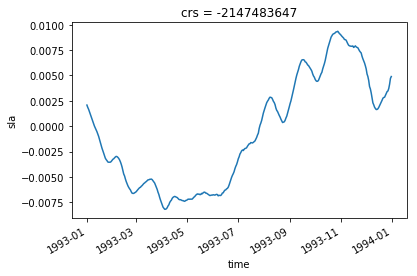

In [9]:
sla_timeseries.plot()

In [ ]:
# Local Test
# ds.to_zarr('zarrlocal')
ds_localzarr = xr.open_zarr('zarrlocal')
ds_localzarr
%time sla_timeseries = ds_localzarr.sla.mean(dim=('longitude', 'latitude')).load()

In [ ]:
sla_timeseries.plot()

## Connect to GCS
Connect to our cloud storage, upload some data and gather some performance on this task.

In [16]:
# Connect to GCS
# connect to gcs
gcsproj = gcsfs.GCSFileSystem(project='pangeo-181919', token=None)
bucket  = gcsfs.mapping.GCSMap('pangeo-data/storage-benchmarks/', gcs=gcsproj, check=True, create=False)
llc_bucket = gcsfs.mapping.GCSMap('pangeo-data/kai-llc4320-test/', gcs=gcsproj, check=True, create=False)
gcsproj.ls('pangeo-data')

['pangeo-data/test999/',
 'pangeo-data/kai-llc4320-test/',
 'pangeo-data/FIB-25/',
 'pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3-alt/',
 'pangeo-data/newman-met-ensemble-full/',
 'pangeo-data/dataset-duacs-rep-global-merged-allsat-phy-l4-v3/',
 'pangeo-data/llc4320/',
 'pangeo-data/test998/',
 'pangeo-data/storage-benchmarks/',
 'pangeo-data/test997/',
 'pangeo-data/newmann-met-ensemble-netcdf/',
 'pangeo-data/newman-met-ensemble/']

In [ ]:
with dask.set_options(get=dask.threaded.get):
    with ProgressBar():
        ds.to_zarr(store=bucket)

In [ ]:
# Delete data in case something goes wrong.
! gsutil -q -m rm -r gs://pangeo-data/storage-benchmarks/*

In [6]:
with dask.set_options(get=dask.threaded.get):
    with ProgressBar():
        ds_zarr = xr.open_zarr(bucket)
ds_zarr

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 365)
Coordinates:
    crs        int32 ...
    lat_bnds   (latitude, nv) float32 dask.array<shape=(720, 2), chunksize=(720, 2)>
  * latitude   (latitude) float32 -89.875 -89.625 -89.375 -89.125 -88.875 ...
    lon_bnds   (longitude, nv) float32 dask.array<shape=(1440, 2), chunksize=(1440, 2)>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 1.125 1.375 1.625 ...
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 1993-01-03 ...
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
    err        (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
    sla        (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunksize=(1, 720, 1440)>
    ugos       (time, latitude, longitude) float64 dask.array<shape=(365, 720, 1440), chunk

In [7]:
%time sla_timeseries_zarr = ds_zarr.sla.mean(dim=('longitude', 'latitude')).load()
%time sla_timeseries = ds.sla.mean(dim=('longitude', 'latitude')).load()

[########################################] | 100% Completed | 36.6s
CPU times: user 51.4 s, sys: 19.9 s, total: 1min 11s
Wall time: 37 s
[########################################] | 100% Completed |  1min 10.9s
CPU times: user 18.8 s, sys: 9.34 s, total: 28.2 s
Wall time: 1min 10s


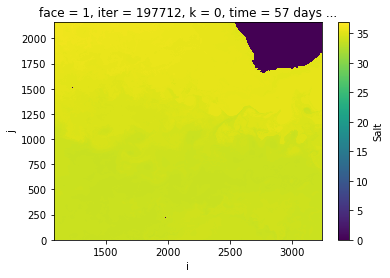

In [15]:
# Upload some LLC4320 Data
llc_single = '/swot/SUM01/LLC/llc_4320_agulhas/llc_4320_agulhas.0000197712.nc'
#all_files = sorted(glob(ddir + '????/*.nc'))
#one_year_files = sorted(glob(ddir + '1993/*.nc'))

ds_llc = xr.open_dataset(llc_single, autoclose=True)


In [17]:
ds_llc.to_zarr(store=llc_bucket)